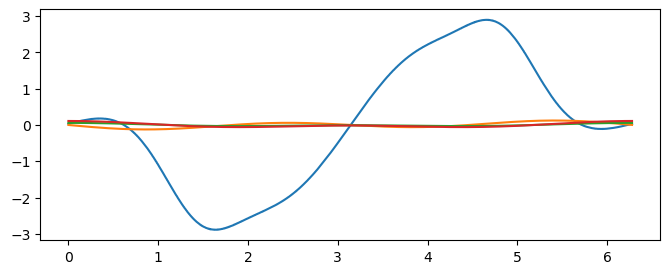

In [91]:
# solving the coupled ODE system: coeff_dp dt y = vb - (coeff + coeff_dc dchi) y
# where t is phi grid indices going from 0 to n_row
# while ignoring the center 1 or 2 rows of vb, y and coeffs.
# Coeffs are all convolution matrices.

# dy_dt, where t is col index

n_eval = 4
num_phi = loop_suppressing_B_theta_nm1.get_shape()[1]
phis_looped = np.linspace(0,2*np.pi,num_phi+1)
f_content_looped = scipy.interpolate.interp1d(phis_looped, wrap_grid_content_jit(loop_suppressing_B_theta_nm1.content))
coeff_content_looped = scipy.interpolate.interp1d(phis_looped, wrap_grid_content_jit(test_equilibrium.coeff_B_theta_nm1.content))
coeff_dc_content_looped = scipy.interpolate.interp1d(phis_looped, wrap_grid_content_jit(test_equilibrium.coeff_dc_B_theta_nm1.content))
coeff_dp_content_looped = scipy.interpolate.interp1d(phis_looped, wrap_grid_content_jit(test_equilibrium.coeff_dp_B_theta_nm1.content))

plt.plot(phis, f_content_looped(phis)[0])
plt.plot(phis, coeff_content_looped(phis)[0])
plt.plot(phis, coeff_dc_content_looped(phis)[0])
plt.plot(phis, coeff_dp_content_looped(phis)[0])

In [77]:
# scipy's odeint solves for dyn/dt = dt(yn, t)
# This is the dt(yn, t) for B_psi_nm1
# y is a looped content

# y: B_theta components at a given phi. Must have n_eval-2 or n_eval-3 components.
# t_in: t is looped index from 0 to 1000. Since solve_ivp takes t below 100, t_in is scaled.
def dt_y_B_theta_nm1(phi, y_input, B_theta_0 = None):
    
    # When n_eval is even, y is odd. y_looped is B_psi[n-1] when n_eval is 
    # even, but is B_psi[n-1] with the zero comp removed when n_eval is odd.
    # We add a zero component to y during odd n_eval for convenience.
    if n_eval%2==1:
        if not B_theta_0:
            raise AttributeError('B_theta_0 not provided')
        y = add_center(y_input, B_theta_0)
    else:
        y = y_input
        
    dc_y = 1j*np.linspace(-(n_eval-3), n_eval-3, n_eval-2)*y
    
    coeff_dc_matrix_phi = conv_matrix(coeff_dc_content_looped(phi), n_eval-2)
    coeff_matrix_phi = conv_matrix(coeff_content_looped(phi), n_eval-2)
    # RHS vector
    RHS_with_center_comp = \
        f_content_looped(phi) \
        - coeff_matrix_phi @ y \
        - coeff_dc_matrix_phi @ dc_y
        
    RHS = remove_center(RHS_with_center_comp)
    
    coeff_dp_matrix_phi_sq = remove_center(conv_matrix(coeff_dp_content_looped(phi), n_eval-2))
    inv = np.linalg.inv(coeff_dp_matrix_phi_sq)
    
    return(np.linalg.inv(coeff_dp_matrix_phi_sq)@RHS)#/19.022e-01*(1-0.0001114)/5) # Stuff behind are fudge factors. Doesn't work.
    
def dt_y_B_theta_nm1_2d(phis, ys, B_theta_0 = None):
    out = np.zeros_like(ys)
    for i in range(len(phis)):
        out[:, i] = dt_y_B_theta_nm1(phi[i], ys[:,i], B_theta_0)
    return(out)

## Testing dphiy callable
Still trying to solve $(C + C_\chi \partial_\chi + C_\phi \partial_\phi)y = f(\chi, \phi)$

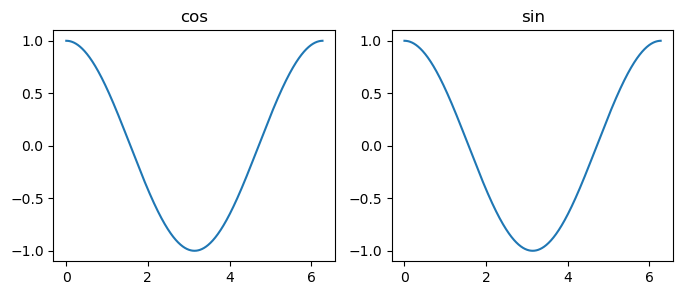

In [78]:
test = ChiPhiFuncGrid(np.array([np.cos(phis), np.cos(phis)]), fourier_mode = True)
test.display_content()


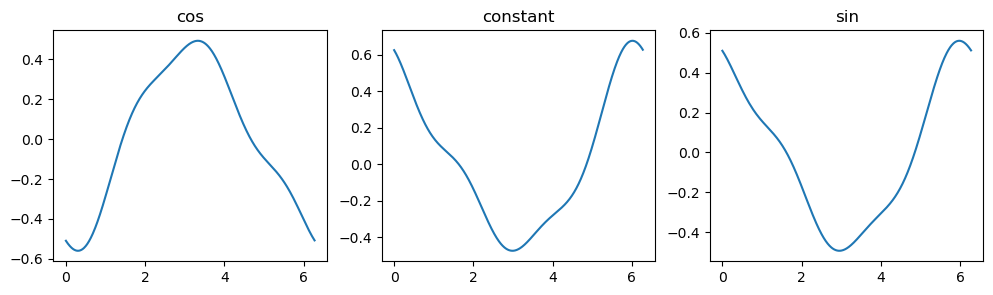

In [79]:
test_RHS = test_equilibrium.coeff_B_theta_nm1*test\
    + test_equilibrium.coeff_dc_B_theta_nm1*test.dchi()\
    + test_equilibrium.coeff_dp_B_theta_nm1*test.dphi()
test_RHS.display_content()
f_content_looped = scipy.interpolate.interp1d(phis_looped, wrap_grid_content_jit(test_RHS.content))

A


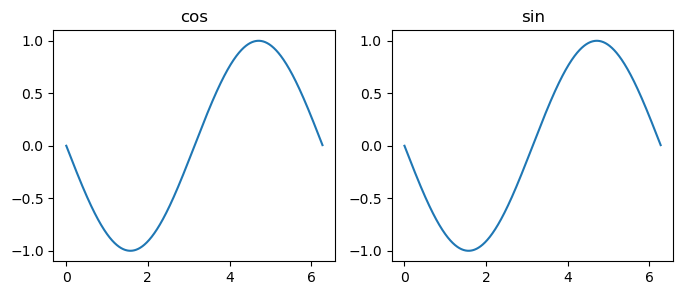

B


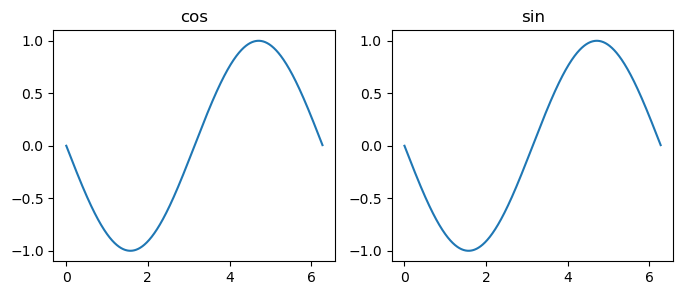

Difference


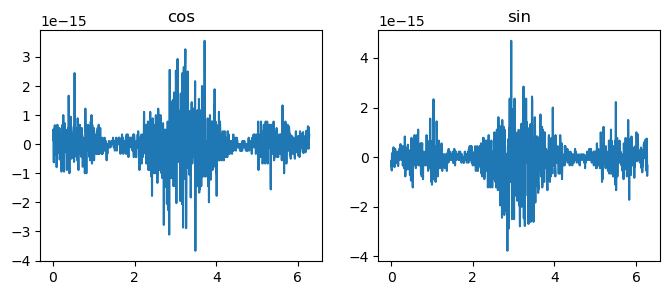

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.762e-04       2.132e-16      
Worst:          1.731e-01       1.832e-15      
Std             5.471e-03       2.55e-16       
Total imaginary component
0.0



In [80]:
# Everything is 2.8x off. Even if this factor is found, 
# numerical noise would still cause the solution to damp
# or diverge

new_content = dt_y_B_theta_nm1_2d(phis, test.content)
compare_chiphifunc(ChiPhiFuncGrid(new_content), test.dphi())

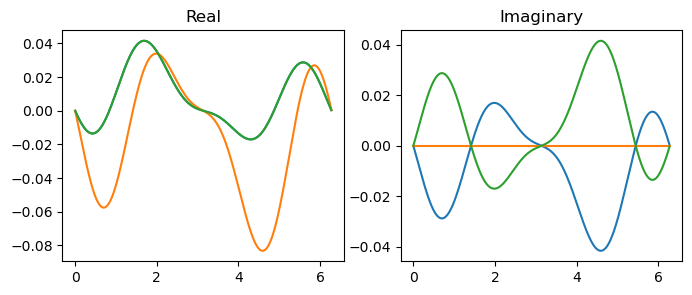

In [81]:
(test_equilibrium.coeff_dp_B_theta_nm1*test.dphi()).display_content(fourier_mode = False)

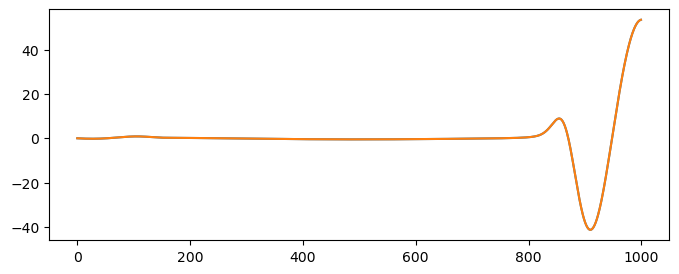

In [83]:
B_theta_sln = scipy.integrate.solve_ivp(dt_y_B_theta_nm1, (0,np.pi*2), [+0j,0j], dense_output=True)
B_theta_sln.keys()
plt.plot(B_theta_sln.sol(phis).T)

In [102]:
def bc(ya, yb):
    return(ya-yb)
B_theta_sln = scipy.integrate.solve_bvp(dt_y_B_theta_nm1_2d, bc, np.linspace(0,np.pi*2,1000),
                                        np.zeros((2,1000),dtype = np.complex128), tol=0.0001)

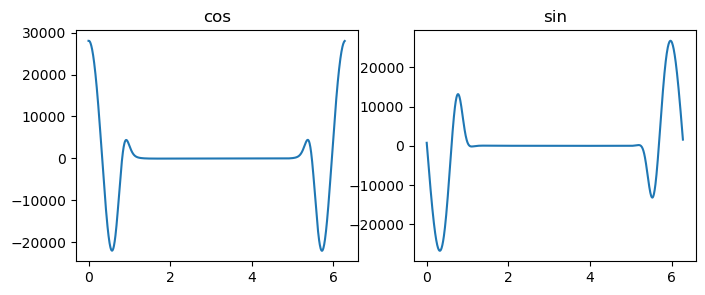

In [103]:
B_theta = ChiPhiFuncGrid(B_theta_sln.sol(phis))
B_theta.display_content()

In [104]:
test_LHS = test_equilibrium.coeff_B_theta_nm1*B_theta\
    + test_equilibrium.coeff_dc_B_theta_nm1*B_theta.dchi()\
    + test_equilibrium.coeff_dp_B_theta_nm1*B_theta.dphi()

A


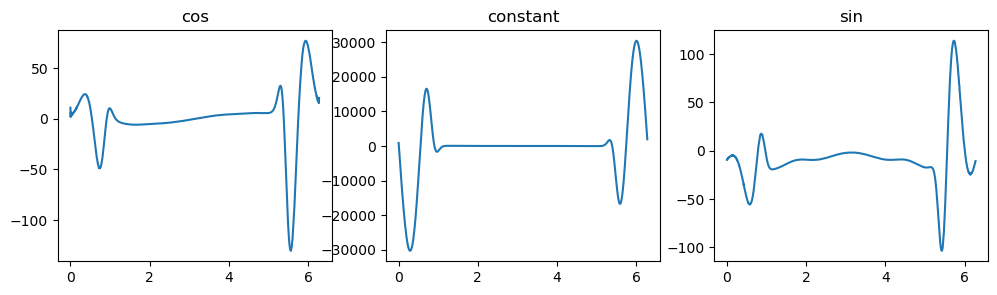

B


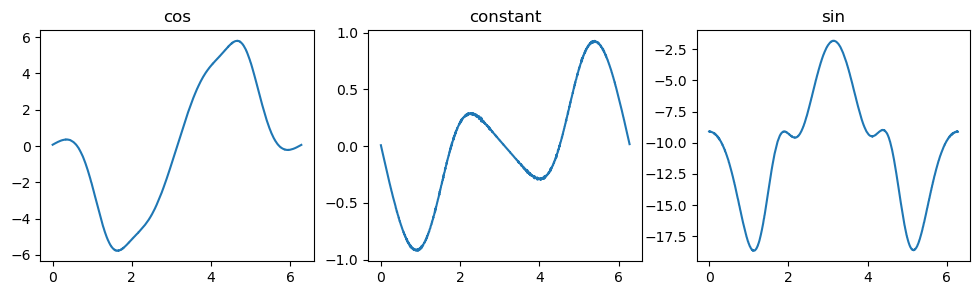

Difference


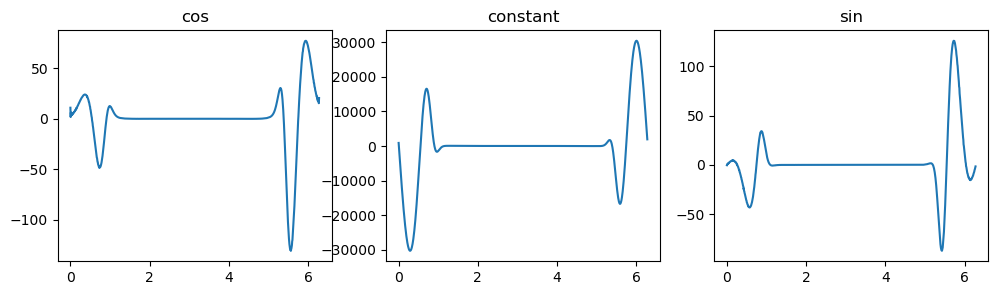

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            4.385e+03       1.516e+03      
Worst:          1.191e+05       3.045e+04      
Std             1.751e+04       5.397e+03      
Total imaginary component
0.0



In [106]:
compare_chiphifunc(test_LHS,loop_suppressing_B_theta_nm1)